# Compare different DICOM conversions

Different methods of converting DICOM to images are compared.

### There is a **significant** difference between images that do and do not require GDCM. 

### There is additionally a significant difference between lossless images that have the exact same TransferSyntaxUID name.

Images with a TransferSyntaxUID that includes 'JPEG Lossless' may need to be converted differently from 'Implicit'. The function dcm_apply_windows is the most consistent between the three. By playing with the window and level, the bone is better seen. The value from the dicom metadata is overridden by the preset values. 

Would love to hear ideas from the community about ways to address this.

In [1]:
! pip install pylibjpeg -q
! pip install python-gdcm -q
! pip install pylibjpeg-libjpeg -q

In [2]:
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from PIL import Image

import matplotlib.image as mpimg
import cv2

In [3]:
root = Path('../input/rsna-2022-cervical-spine-fracture-detection')
train_folder = root/'train_images'
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
study_ids = train_df.StudyInstanceUID.unique()

In [4]:
def get_fn(study_id, slice):
    return train_folder/study_id/f'{slice}.dcm'

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-2000., -1509., -1018.,  -527.,   -36.,   455.,   946.,  1437.,
         1928.,  2419.,  2910.]),
 <a list of 512 BarContainer objects>)

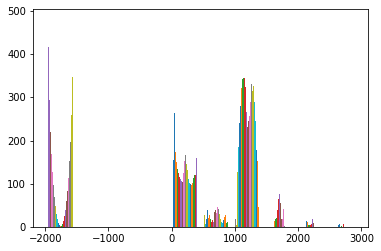

In [5]:
fn = get_fn('1.2.826.0.1.3680043.10001',100)
dcm = pydicom.dcmread(fn)
arr = dcm.pixel_array
plt.hist(arr)

# Conversion Functions

In [6]:
#my function

def dcm_apply_windows(dcm, width = None, level = None):
    arr = dcm.pixel_array
    #slope, intercept
    slope = 1
    intercept = 0
    if "RescaleIntercept" in dcm and "RescaleSlope" in dcm:
        intercept = int(dcm.RescaleIntercept)
        slope = int(dcm.RescaleSlope)

    arr = arr * slope + intercept

    #window
    if width is None or level is None:
        width,level = get_window_from_dicom(dcm)
    arr = np.clip(arr, level - width // 2, level + width // 2)

    #scale
    #this was fixed
    arr = (((arr - np.min(arr)) / np.max(arr)) * 256).astype(np.uint8) 
    return arr


# def dcm_apply_windows_old(dcm, scale = False):
#     """
#     Applies Intercept/Slope and Window Center/Width
#     """
#     arr = dcm.pixel_array
#     #slope, intercept
#     slope = 1
#     intercept = 0
#     if "RescaleIntercept" in dcm and "RescaleSlope" in dcm:
#         intercept = int(dcm.RescaleIntercept)
#         slope = int(dcm.RescaleSlope)
        
#     arr = arr * slope + intercept
    
#     #window
#     width,level = get_window_from_dicom(dcm)
#     if width is not None and level is not None:
#         arr = np.clip(arr, level - width // 2, level + width // 2)
        
#      #scale
#     if scale:
#         arr = (((arr - np.min(arr)) / np.max(arr)) * 256).astype(np.uint8)
        
#     return arr

def get_window_from_dicom(dcm, default = (2000, 500)):
    """
    Returns window width and window center values or first example if MultiValue
    Strips comma from value if present (seen in a different dataset)
    If no window width/level is provided or available, returns default.
    """
    width, level = default

    if "WindowWidth" in dcm:
        width = dcm.WindowWidth
        if isinstance(width, pydicom.multival.MultiValue):
            width = float(width[0])
        else:
            width = float(str(width).replace(',', ''))

    if "WindowCenter" in dcm:
        level = dcm.WindowCenter
        if isinstance(level, pydicom.multival.MultiValue):
            level = float(level[0])
        else:
            level = float(str(level).replace(',', ''))
            
    return width, level

In [7]:
def read_dicom(path, voi_lut = True, fix_monochrome = True):
    '''ref: https://www.kaggle.com/code/raddar/convert-dicom-to-np-array-the-correct-way
    '''
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data, dicom

In [8]:
#Code from:
#https://www.kaggle.com/code/thedevastator/tf-rsna-efficient-net-baseline
#https://www.kaggle.com/code/realneuralnetwork/rsna-efficientnet-infer
def load_dicom_from_path(path, size = 512):
    try:
        dcm = pydicom.dcmread(path)
        dcm.PhotometricInterpretation = 'YBR_FULL'
        data=dcm.pixel_array
        data=data-np.min(data)
        if np.max(data) != 0:
            data=data/np.max(data)
        data=(data*255).astype(np.uint8)        
        return cv2.cvtColor(data.reshape(size, size), cv2.COLOR_GRAY2RGB)
    except:     
        print('Error')
        return np.zeros((size, size, 3))

In [9]:
def show_conversions(path):
    plt.figure(figsize=(20, 20))

    r = 5
    c = 5

    ax = plt.subplot(r,c, 1)
    ax.set_title('read_dicom, no lut')
    arr, _ = read_dicom(path, voi_lut = False)
    im = Image.fromarray(arr)
    plt.axis('off')   
    plt.imshow(im,cmap='bone')

    ax = plt.subplot(r,c, 2)
    ax.set_title('read_dicom, + lut')
    arr, _ = read_dicom(path, voi_lut = True)
    im = Image.fromarray(arr)
    plt.axis('off')   
    plt.imshow(im,cmap='bone')

    ax = plt.subplot(r,c, 3)
    ax.set_title('load_dicom_from_path')
    im = load_dicom_from_path(path)
    plt.axis('off')   
    plt.imshow(im[:,:,0], cmap='bone')

    ax = plt.subplot(r,c, 4)
    ax.set_title('dcm_apply_windows')
    dcm = pydicom.dcmread(path)
    arr = dcm_apply_windows(dcm)
    im = Image.fromarray(arr)
    plt.axis('off')   
    plt.imshow(im,cmap='bone')

    ax = plt.subplot(r,c, 5)
    ax.set_title('dcm_apply_windows + 2000/600')
    dcm = pydicom.dcmread(path)
    arr = dcm_apply_windows(dcm,width=2000,level=600)
    im = Image.fromarray(arr)
    plt.axis('off')   
    plt.imshow(im,cmap='bone')

    ax = plt.subplot(r,c, 6)
    ax.set_title('raw')
    arr = dcm.pixel_array
    im = Image.fromarray(arr)
    plt.axis('off')   
    plt.imshow(im,cmap='bone')

    ax = plt.subplot(r,c, 7)
    ax.set_title('slope & intercept only')
    arr = dcm.pixel_array
    slope = 1
    intercept = 0
    if "RescaleIntercept" in dcm and "RescaleSlope" in dcm:
        intercept = int(dcm.RescaleIntercept)
        slope = int(dcm.RescaleSlope)
    arr = arr * slope + intercept
    im = Image.fromarray(arr)
    plt.axis('off')   
    plt.imshow(im,cmap='bone')

    ax = plt.subplot(r,c, 8)
    ax.set_title('WW & WC only')
    arr = dcm.pixel_array
    width,level = get_window_from_dicom(dcm)
    arr = np.clip(arr, level - width // 2, level + width // 2)
    im = Image.fromarray(arr)
    plt.axis('off')   
    plt.imshow(im,cmap='bone')

# Comparison

# Image without GDCM requirement

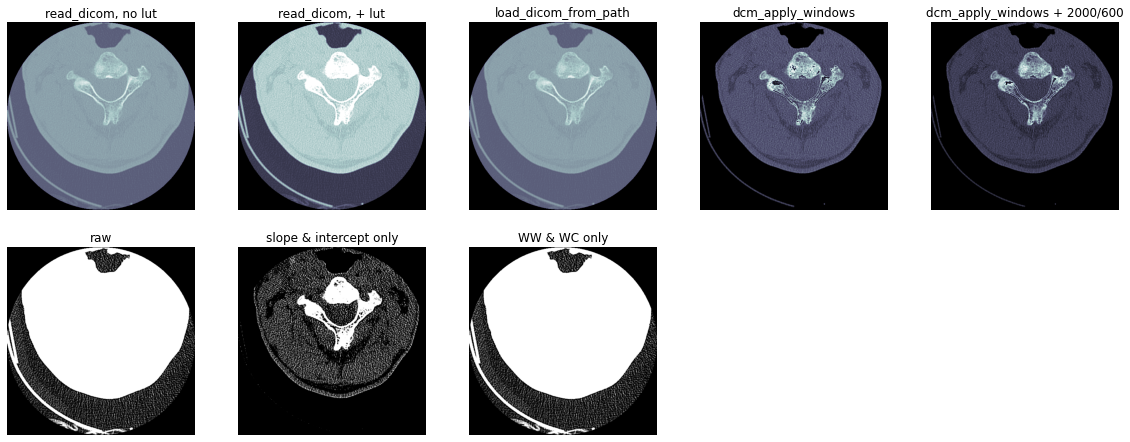

In [10]:
filename_1 = get_fn('1.2.826.0.1.3680043.10001',100)
show_conversions(filename_1)

# Image with GDCM requirement - JPEG Lossless

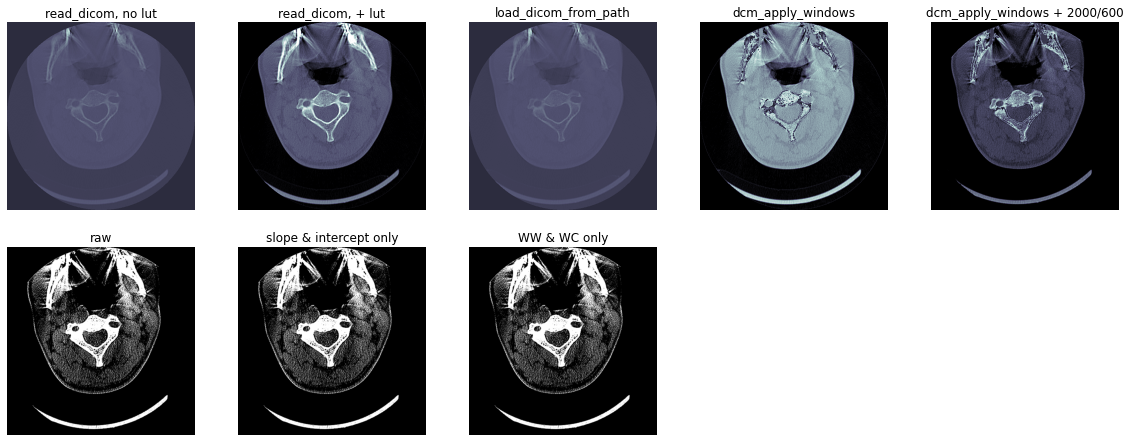

In [11]:
#requires GDCM
filename_2 = get_fn(study_ids[100],100)
show_conversions(filename_2)

# Different JPEG Lossless

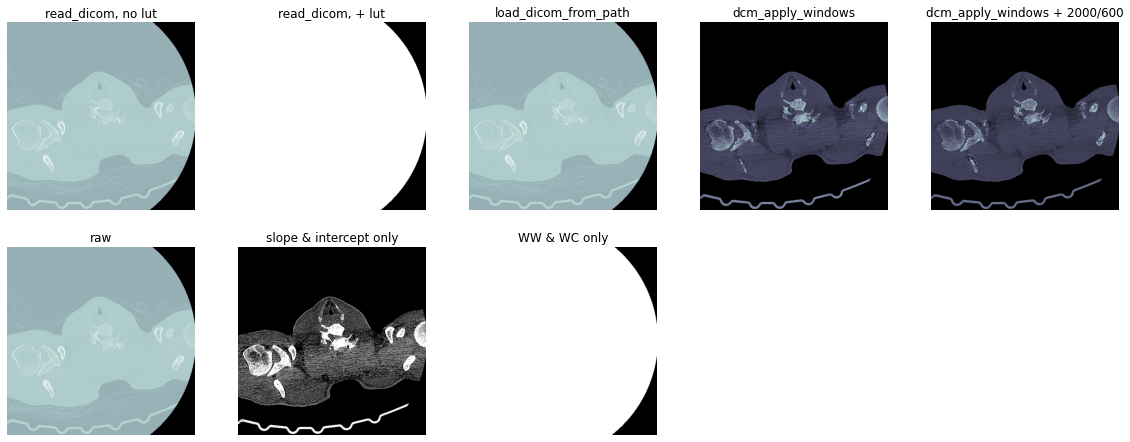

In [12]:
study_id = '1.2.826.0.1.3680043.23904'
#requires GDCM
filename_3 = get_fn(study_id,180)
show_conversions(filename_3)

# DICOM values for the sample images

In [13]:
pydicom.dcmread(filename_1, stop_before_pixels=True)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10001.1.100
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10001.1.100
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '175846.414022'
(0010, 0010) Patient's Name                      PN: '10001'
(0010, 0020) Patient ID                          LO: '10001'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

In [14]:
pydicom.dcmread(filename_2, stop_before_pixels=True)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.18696.1.100
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.18696.1.100
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '185256.184296'
(0010, 0010) Patient's Name                      PN: '18696'
(0010, 0020) Patient ID                          LO: '18696'
(0018, 0050) Slice Thickness                     DS: '1.0'

In [15]:
pydicom.dcmread(filename_3, stop_before_pixels=True)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.23904.1.180
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.23904.1.180
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183046.388677'
(0010, 0010) Patient's Name                      PN: '23904'
(0010, 0020) Patient ID                          LO: '23904'
(0018, 0050) Slice Thickness                     DS: '0.8'